In [1]:
#Import Requried Labriarys 

import ee
import json
import datetime
import matplotlib.pyplot as plt
import geemap

In [2]:
# Initialize the Earth Engine module
ee.Initialize()

In [3]:
# Load the GeoJSON file 
geojson_path = 'C:/Users/Bandesh/Bandesh/new_task/Tb/tb_waterbody.geojson'  
with open(geojson_path) as f:
    geojson_data = json.load(f)
    region = geojson_data['features'][0]['geometry']


# Convert the GeoJSON to an Earth Engine geometry
geometry_type = region['type']
coordinates = region['coordinates']

# Handle Polygon and MultiPolygon geometries
if geometry_type == 'Polygon':
    aoi = ee.Geometry.Polygon(coordinates)
elif geometry_type == 'MultiPolygon':
    aoi = ee.Geometry.MultiPolygon(coordinates)
else:
    raise ValueError("Unsupported geometry type")

# Print the AOI to verify
print("AOI:", aoi.getInfo())


AOI: {'type': 'Polygon', 'coordinates': [[[76.24953588102186, 15.239972024837648], [76.24407819764262, 15.231005830714622], [76.23940018331757, 15.239972024837648], [76.23433233446542, 15.252836564231554], [76.22575597486949, 15.255175571394082], [76.22068812601734, 15.26180275835458], [76.21016259378597, 15.2676502762609], [76.21639994621937, 15.250887391596114], [76.20782358662343, 15.25361623328573], [76.19963706155458, 15.246989046325233], [76.19456921270243, 15.257124744029523], [76.18872169479612, 15.24581954274397], [76.18092500425435, 15.254785736866994], [76.17039947202298, 15.241531362946], [76.15948410526451, 15.241141528418913], [76.15129758019566, 15.24542970821688], [76.14467039323516, 15.238412686729296], [76.14583989681643, 15.224378643754125], [76.15324675283111, 15.213073442468572], [76.14155171701846, 15.198259730439226], [76.14778906945187, 15.181496845774438], [76.15714509810198, 15.185395191045318], [76.16922996844171, 15.20527675192681], [76.18248434236271, 15.22

In [4]:
# Landsat image collection
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
          .filterBounds(aoi) \
          .filterDate('2020-01-01', '2021-01-01')

In [5]:
# Get the first image from the collection 
landsat_image = landsat.first()

In [20]:
# Clip the image to the AOI
clipped_image = landsat_image.clip(aoi)

# centroid of the AOI
centroid = aoi.centroid()

# Using geemap to display the clipped image
Map = geemap.Map(center=[centroid.coordinates().get(1).getInfo(), centroid.coordinates().get(0).getInfo()], zoom=10)
Map.addLayer(clipped_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Clipped Landsat Image')
Map.addLayer(aoi, {}, 'AOI')
Map

Map(center=[15.223592346819586, 76.25405306343612], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# NDWI Calculations
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B5']).rename('NDWI')
    return image.addBands(ndwi)

In [8]:
# Apply the NDWI calculation
landsat_ndwi = landsat.map(calculate_ndwi)

In [9]:
# calculate monthly mean NDWI
def monthly_mean(img_col, aoi):
    def wrap(date):
        start_date = ee.Date(date)
        end_date = start_date.advance(1, 'month')
        monthly_col = img_col.filterDate(start_date, end_date)
        mean_img = monthly_col.mean().set('system:time_start', start_date)
        return mean_img.clip(aoi)
    
    dates = ee.List.sequence(0, 11).map(lambda m: ee.Date('2020-01-01').advance(m, 'month'))
    monthly_col = ee.ImageCollection(dates.map(wrap))
    return monthly_col

# Calculate monthly mean NDWI
monthly_ndwi = monthly_mean(landsat_ndwi.select('NDWI'), aoi)

In [10]:
#calculate surface water extent
def calculate_water_extent(ndwi_img, threshold=0.3):
    water_mask = ndwi_img.gt(threshold).selfMask()
    water_area = water_mask.multiply(ee.Image.pixelArea())
    total_area = water_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        bestEffort=True
    ).get('NDWI')
    return ee.Feature(None, {'water_extent': total_area, 'date': ndwi_img.get('system:time_start')})

In [11]:
# Time series data for visualization
def get_time_series(image_collection, region, reducer=ee.Reducer.mean()):
    def reduce_region(image):
        stat = image.reduceRegion(
            reducer=reducer,
            geometry=region,
            scale=30,
            bestEffort=True
        )
        return ee.Feature(None, stat).set('date', image.get('system:time_start'))
    
    feature_collection = image_collection.map(reduce_region).filter(ee.Filter.notNull(['NDWI']))
    return feature_collection

# Reduce the monthly NDWI collection to a feature collection
time_series = get_time_series(monthly_ndwi, aoi)

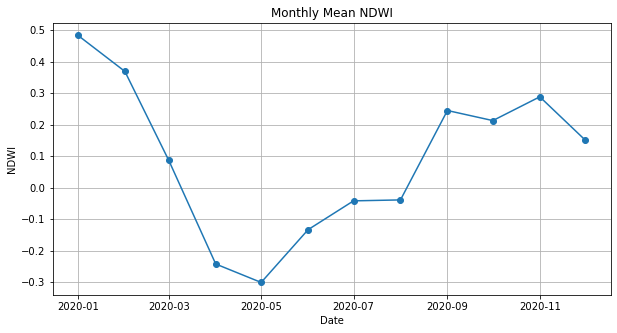

In [16]:
# Converting the feature collection to a list of dictionaries
ndwi_list = time_series.getInfo()['features']

# Extracting dates and NDWI values
dates = [datetime.datetime.utcfromtimestamp(feature['properties']['date']['value'] / 1000) for feature in ndwi_list]
ndwi_values = [feature['properties']['NDWI'] for feature in ndwi_list]

# Plotting Monthly Mean NDWI 
plt.figure(figsize=(10, 5))
plt.plot(dates, ndwi_values, marker='o')
plt.title('Monthly Mean NDWI')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.grid(True)
# Save the plot to a PNG file
plt.savefig('C:/Users/Bandesh/Bandesh/new_task/Tb/ndwi_mean_plot.png')
plt.show()

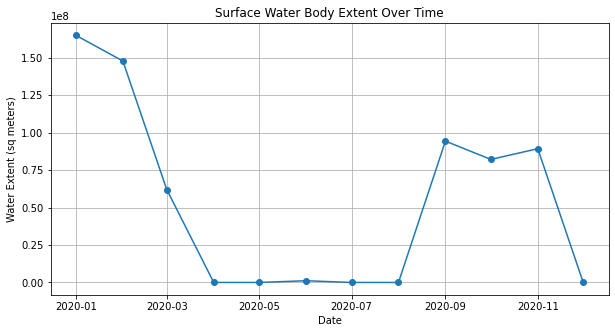

In [17]:
# Calculate the surface water body extent for each monthly NDWI image
water_extent_fc = monthly_ndwi.map(lambda img: calculate_water_extent(img))

# Converting the feature collection to a list of dictionaries
water_extent_list = water_extent_fc.getInfo()['features']

# Extracting dates and water extent values
dates_water_extent = [datetime.datetime.utcfromtimestamp(feature['properties']['date']['value'] / 1000) for feature in water_extent_list]
water_extent_values = [feature['properties']['water_extent'] for feature in water_extent_list]

# Plotting line Graphs Surface Water Body Extent Over Time Periods
plt.figure(figsize=(10, 5))
plt.plot(dates_water_extent, water_extent_values, marker='o')
plt.title('Surface Water Body Extent Over Time')
plt.xlabel('Date')
plt.ylabel('Water Extent (sq meters)')
plt.grid(True)
plt.savefig('C:/Users/Bandesh/Bandesh/new_task/Tb/surface_waterbody_extent_plot.png')
plt.show()

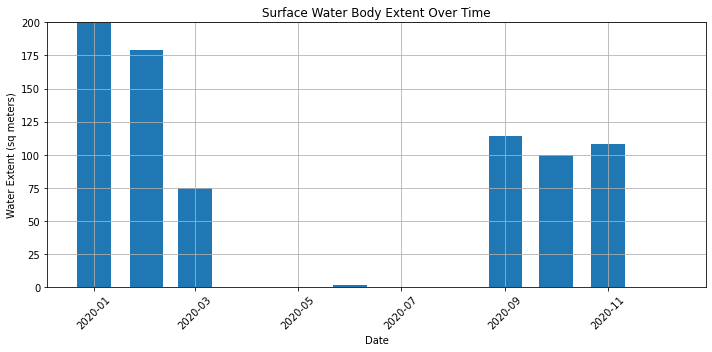

In [22]:
# Extracting dates and water extent values
dates_water_extent = [datetime.datetime.utcfromtimestamp(feature['properties']['date']['value'] / 1000) for feature in water_extent_list]
water_extent_values = [feature['properties']['water_extent'] for feature in water_extent_list]

# Normalize the water extent values to the range [0, 200]
max_extent = max(water_extent_values)
if max_extent != 0:
    water_extent_values = [min(200, val * 200 / max_extent) for val in water_extent_values]

# Plotting  2D column chart for Surface Water Body Extent Over Time Periods
plt.figure(figsize=(10, 5))
plt.bar(dates_water_extent, water_extent_values, width=20)  # Adjust width of bars as needed
plt.title('Surface Water Body Extent Over Time')
plt.xlabel('Date')
plt.ylabel('Water Extent (sq meters)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 200)  # Set y-axis limits from 0 to 200
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('C:/Users/Bandesh/Bandesh/new_task/Tb/surface_waterbody_extent_barchart_plot.png')
plt.show()

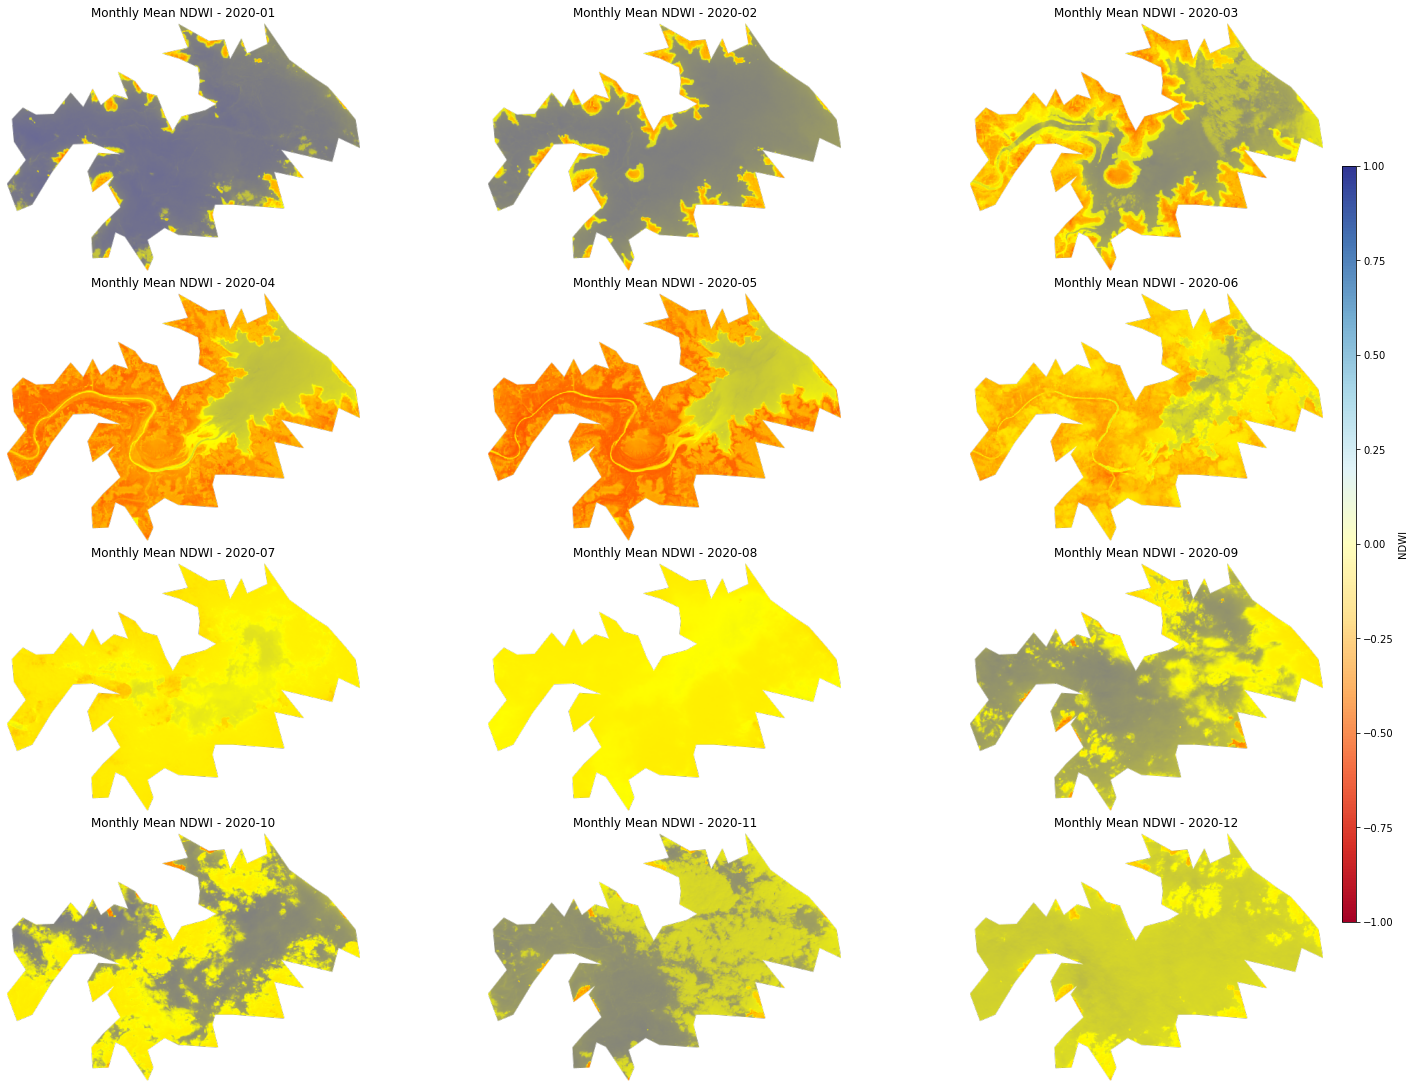

In [19]:
# Visualize the monthly mean NDWI images clipped to the AOI.
num_images = monthly_ndwi.size().getInfo()
monthly_ndwi_list = monthly_ndwi.toList(num_images)

# Set up the subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), constrained_layout=True)
axes = axes.flatten()

for i in range(num_images):
    # Get the image
    image = ee.Image(monthly_ndwi_list.get(i))
    
    # Clip the image to the AOI
    clipped_image = image.clip(aoi)
    
    # Get the date
    date = ee.Date(clipped_image.get('system:time_start')).format('YYYY-MM').getInfo()
    
    # Use geemap to get the RGB visualization of the NDWI image
    vis_params = {
        'min': -1,
        'max': 1,
        'palette': ['red', 'yellow', 'blue']
    }
    
    ndwi_url = clipped_image.getThumbURL({
        'bands': 'NDWI',
        'min': -1,
        'max': 1,
        'palette': ['red', 'yellow', 'blue'],
        'dimensions': 512
    })
    
    ndwi_img = plt.imread(ndwi_url)
    
    # Plot the NDWI image
    ax = axes[i]
    im = ax.imshow(ndwi_img, vmin=-1, vmax=1, cmap='RdYlBu')
    ax.set_title(f'Monthly Mean NDWI - {date}')
    ax.axis('off')

# Create a color bar
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label='NDWI')
plt.savefig('C:/Users/Bandesh/Bandesh/new_task/Tb/Monthly_ndwi_mean_images.png')

plt.show()